In [ ]:
words = open('names.txt', 'r').read().splitlines()

In [ ]:
len(words)

32033

In [ ]:
import torch

In [ ]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        trigram = (ch1, ch2, ch3)
        b[trigram] = b.get(trigram, 0) + 1
sorted(b.items(), key=lambda k: -k[1])

[(('a', 'h', '<E>'), 1714),
 (('n', 'a', '<E>'), 1673),
 (('a', 'n', '<E>'), 1509),
 (('o', 'n', '<E>'), 1503),
 (('<S>', 'm', 'a'), 1453),
 (('<S>', 'j', 'a'), 1255),
 (('<S>', 'k', 'a'), 1254),
 (('e', 'n', '<E>'), 1217),
 (('l', 'y', 'n'), 976),
 (('y', 'n', '<E>'), 953),
 (('a', 'r', 'i'), 950),
 (('i', 'a', '<E>'), 903),
 (('i', 'e', '<E>'), 858),
 (('a', 'n', 'n'), 825),
 (('e', 'l', 'l'), 822),
 (('a', 'n', 'a'), 804),
 (('i', 'a', 'n'), 790),
 (('m', 'a', 'r'), 776),
 (('i', 'n', '<E>'), 766),
 (('e', 'l', '<E>'), 727),
 (('y', 'a', '<E>'), 716),
 (('a', 'n', 'i'), 703),
 (('<S>', 'd', 'a'), 700),
 (('l', 'a', '<E>'), 684),
 (('e', 'r', '<E>'), 683),
 (('i', 'y', 'a'), 669),
 (('l', 'a', 'n'), 647),
 (('<S>', 'b', 'r'), 646),
 (('n', 'n', 'a'), 633),
 (('<S>', 'a', 'l'), 632),
 (('<S>', 'c', 'a'), 628),
 (('r', 'a', '<E>'), 627),
 (('n', 'i', '<E>'), 625),
 (('<S>', 'a', 'n'), 623),
 (('n', 'n', '<E>'), 619),
 (('n', 'e', '<E>'), 607),
 (('e', 'e', '<E>'), 605),
 (('e', 'y', '<

In [ ]:
N = torch.zeros((729,27), dtype = torch.int32)
letters = ['.','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

stoi = {s:i for i, s in enumerate(letters)}
itos = {i:s for s, i in stoi.items()}



In [ ]:
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    N[27 * ix1 + ix2, ix3] += 1

KeyError: 27

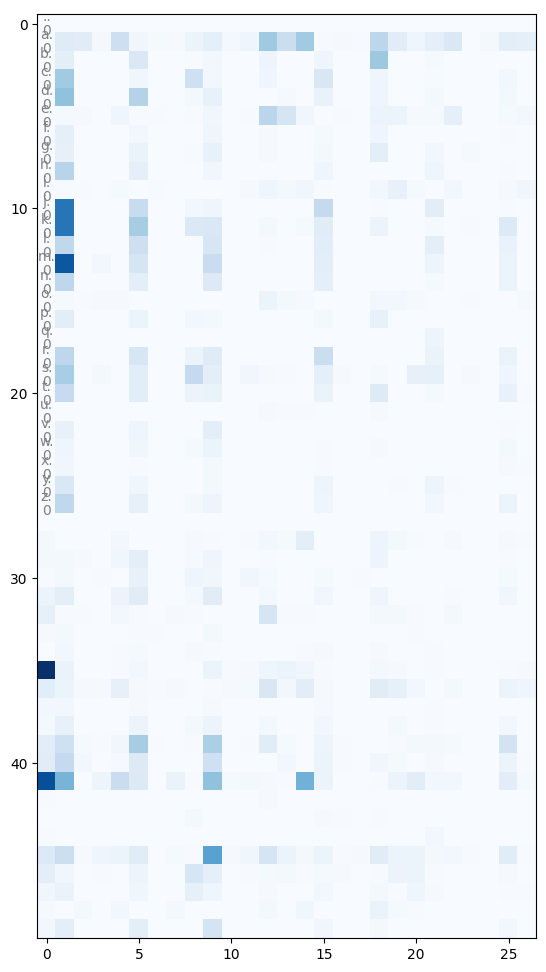

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,12))
plt.imshow(N[:50], cmap='Blues') # This is for visualising the data in a beautiful manner
for k in range(27):
  for i in range(27):
      for j in range(27):
          chstr = itos[27 * i + j]
          chstr_1 = itos[k]
          plt.text(k, 27 * i + j, chstr + chstr_1, ha="center", va="bottom", color='gray')
          plt.text(k, 27 * i + j, N[27 * i + j, k].item(), ha="center", va="top", color='gray')
plt.axis('off');

Neural Network Approach

In [ ]:
import torch.nn.functional as F
import time

In [ ]:
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    xs.append(27 * ix1 + ix2)
    ys.append(ix3)

xs = torch.tensor(xs)
ys = torch.tensor(ys)


In [ ]:
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
xtr, ytr = xs[: n1], ys[: n1]
xdev, ydev = xs[n1: n2], ys[n1: n2]
xtest, ytest = xs[n2: ], ys[n2: ]

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(729, 10)
W1 = torch.rand(10, 50, generator = g)
b1 = torch.rand(50, generator = g)
W2 = torch.rand(50, 27, generator = g)
b2 = torch.rand(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [ ]:
lri, lossi, stepi = [], [], []
start = time.time()
for i in range(1000000):

    # minibatch construct
    ix = torch.randint(0, xtr.shape[0],(64,))

    # forward pass
    emb = C[xtr[ix]]
    h = torch.tanh(emb.view(-1,10) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, ytr[ix]) + (10 ** -3) * (W1 ** 2).mean() + (10 ** -1) * (W2 ** 2).mean()

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -(10 ** -2) *p.grad

    #track stats
    #lri.append(lre[i])
    #lossi.append(loss.item())
    #stepi.append(i)
stop = time.time()
print(stop - start)
print(loss.item())

892.4512238502502
1.8805184364318848


In [ ]:
emb = C[xdev]
h = torch.tanh(emb.view(emb.shape[0],10) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, ydev) + (10 ** -3) * (W1 ** 2).mean() + (10 ** -1) * (W2 ** 2).mean()
loss

tensor(2.0863, grad_fn=<AddBackward0>)

In [ ]:
emb = C[xtest]
h = torch.tanh(emb.view(emb.shape[0],10) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, ytest) + (10 ** -3) * (W1 ** 2).mean() + (10 ** -1) * (W2 ** 2).mean()
loss

tensor(2.4767, grad_fn=<AddBackward0>)

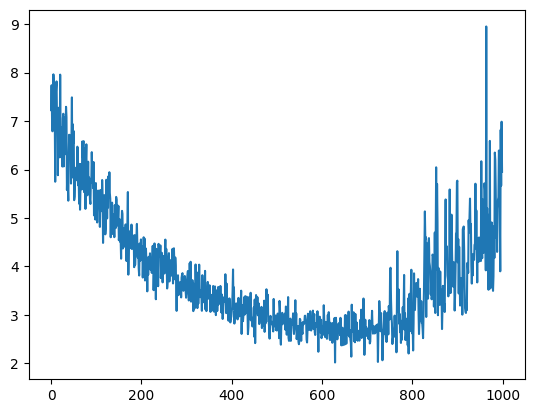

In [ ]:
plt.plot(stepi, lossi) #this was used to get a sense of an ideal learning rate which comes out to be 10 ^ (-0.9)

# **Trials for tuning hyperparameters:-**

A crucial phase in the creation of a machine learning model is hyperparameter tuning. Hyperparameters are predetermined and control the behavior of the learning algorithm itself, in contrast to model parameters, which are learned during training. Efficient adjustment of these hyperparameters can have a major impact on a model's accuracy, performance, and capacity for generalization.
Some of the hyperparameter I worked on are as follows:-

1.   Number of neurons
2.   Batch size
3.   Regularization parameter for weights
4.   Number of iterations

_______________________________________________________________________________


### **1. Number of neurons**
Number of neurons is important to be able to learn the features of the model and produce a generalised pattern. A very high number would sort of memorise the training set and try to replicate it whereas very less would not be able to learn the training data well enough. So asomething in between would be good to be able to learn the trainings set well and be able to generalise. I varied the number of neurons between 20 to 300. I saw a trend that 20, 30 underfitted the model, 100, 200 and 300 overfitted the model and didn't give good results on the dev set. So by hit and trial, I finalised on using 50 neurons for best results.

### **2. Batch Size**
Batch size is important since you cannot be sending the full training set for training due to time and cost constraints. So choosing a good batch size will give the model some idea of how generally the data looks like as well as save time, compute cost to attain good accuracy. I tried batch sizes of 16,32 64 and 128. Below shows how they performed.

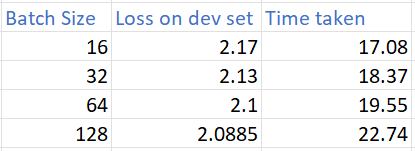

### **3. Regularisation of weights**
We would like to make the weights as small as possible , but still make it achive our target. Hence we introduce this term. We want the training set loss and dev set loss to be almost same. Below are the results.
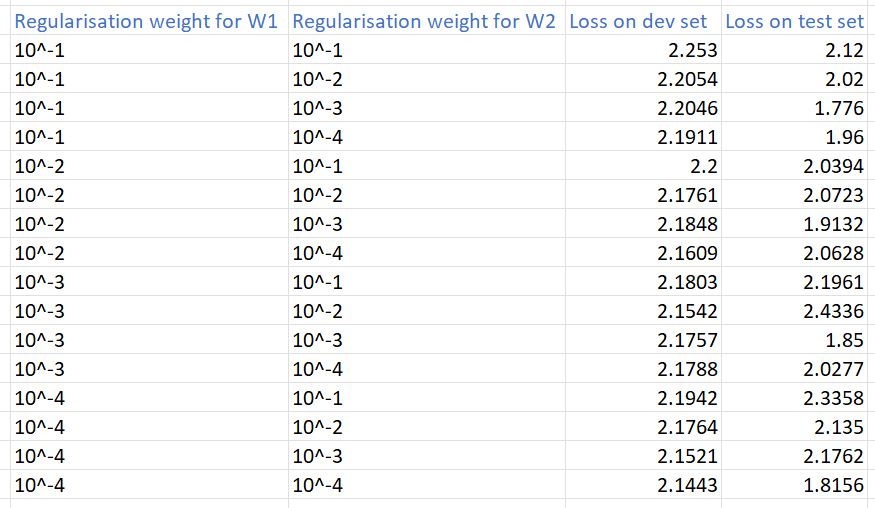


### **4. Number of iterations**
Number of iterations is important so as to give the model a fair chance to correct itself, but it also brings in importance of time. Hence I tried a few possibilities of time. Below are the results.

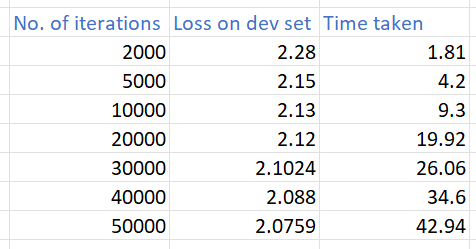


# **Results:-**

Based on the description above, we observe that a batch size of 64, regularisation parameter for W1 as 10^-3 and for W2 as 10^-1 is apt for good performance. If time constraint is present, 40,000 as number of iterations is good as loss then seems to be much lesser impact when compared to the time we put in.

The least loss I attained after running multiple iterations is 2.4767 which is better than the bigram model whose loss was 2.58, worse than the model Andrej Karpathy showed which used three charecters as input and predicted the fourth one whose loss was nearly 2.3.

The dev set was used to train the hyperparameters and the test set was the one based on which the final loss has been reported. Instead of one-hot encoding, I used a matrix which transforms the input in a 10 dimensional space. This way we aren't producing any useless vectors. F.cross_entropy allows faster forward as well as backward propagation. It also doesn't require any smoothening which was needed in the case of negative log likelihood. So computational cost and efficiency is better using this pre-built method as compared to negative log likelihood or actually making the cross entropy functionality ourselves.  

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = ['.', '.']
    while True:
        ix1 = stoi[context[0]]
        ix2 = stoi[context[1]]
        idx = ix1 * 27 + ix2
        emb = C[torch.tensor([idx])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        context = context[1: ] + [itos[ix]]
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))


eria.
yahaylee.
emme.
ella.
evivaniendra.
er.
elyndielie.
empippaleigh.
estana.
evalyn.
elya.
en.
ezra.
egahirie.
even.
evellilanterookura.
yven.
ya.
ellynna.
ima.
